# GEL 

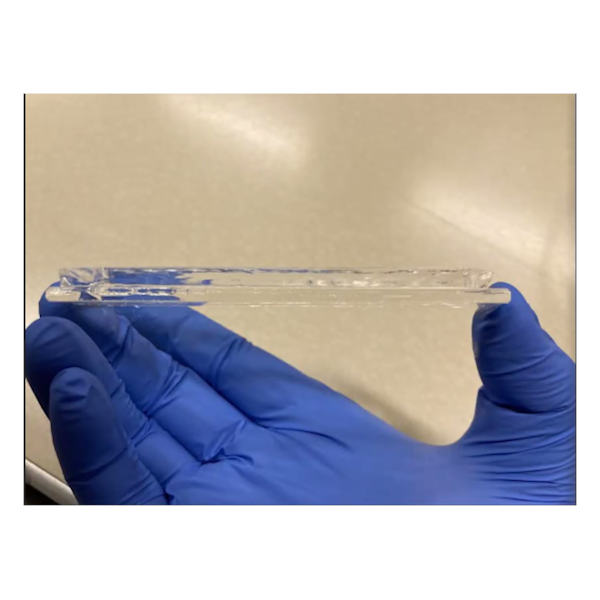

In [1]:
from IPython.display import Image
Image(filename='GELreal.png', width=800)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from ngsolve import *
from netgen.csg import *
from netgen.meshing import MeshingParameters, meshsize
from ngsolve.webgui import Draw

In [3]:
class gel_bonded:
    def __init__(self):
        self.phi0 = 0.2035
        self.entropic_unit = 136.6
        self.G = 0.13
        self.gamma = self.G/self.entropic_unit # 0.0009516837481698391 self.compute_gamma( lamb =1.4874):
        J_iso = 3.2908
        self.lambda_iso = 1.4874 # =J**(1/3)     
        self.lambda_target = 2.1028   
        self.chi =  0.3704756498924026# compute_chi(phi0=0.2035, gamma =0.0009516837481698391, J=J_iso)
        self.geometry_bonded()

    def geometry_bonded(self):
        self.L = 90
        self.d = 1.62
        self.L3 = 15
        left  = Plane (Pnt(-0.5*self.L,0,0), Vec(-1,0,0) )
        right = Plane (Pnt(0.5*self.L,0,0), Vec( 1,0,0) )
        bot   = Plane (Pnt(0,0,0), Vec(0,-1,0) ).bc('bottom')
        top   = Plane (Pnt(0,self.d,0), Vec(0,1,0) )
        back  = Plane (Pnt(0,0,-0.5*self.L3), Vec(0,0, -1) )
        front = Plane (Pnt(0,0,0.5*self.L3), Vec(0,0,1) )
        brick = left * right * front * back * bot * top
        self.geo = CSGeometry()
        self.geo.Add (brick)
        
    def compute_chi( self,phi0, gamma, J):
        phi = phi0/J
        return -phi**(-2) * ((1-1/1000) * phi + log(1-phi) + gamma*J**(-1/3) )
    # compute gamma using free swelling model
    def compute_gamma(self, lamb):
        return -self.dH(lamb**3)*lamb
    # compute gamma using uniaxial approximation
    def gammafun(self,lamb):
        return -self.dH(lamb)/lamb
    def phi(self, J):
        return self.phi0/J

    def H(self, J):
        return (J - self.phi0)*log(1-self.phi(J))  + self.phi0 * self.chi*(1-self.phi(J)) + self.phi0/1000*log(self.phi(J))

    def dH(self, J):
        return (1-1/1000) * self.phi(J) + np.log(1-self.phi(J)) + self.chi * self.phi(J)**2

    # energy density
    def W(self, F):
        J = Det(F)
        C = F.trans* F
        return 0.5*self.gamma * Trace(C) + self.H(J)

In [4]:
class Solve_gel_bonded:
    def __init__(self, gel, maxh=5, corner_refinement=False):
        self.gel = gel
        if corner_refinement:
            mp = self.corner_refinement(maxh=maxh)
            self.mesh = Mesh(gel.geo.GenerateMesh(mp=mp))
        else:
            self.mesh = Mesh(gel.geo.GenerateMesh(maxh=maxh))
        
    def corner_refinement(self, maxh):
        mp = MeshingParameters(maxh=maxh)
        hc = maxh/10
        mp.RestrictH(x = -0.5*self.gel.L, y = 0 , z = -0.5*self.gel.L3 , h = hc)
        mp.RestrictH(x = -0.5*self.gel.L, y = 0 , z = 0.5*self.gel.L3 ,  h = hc)
        mp.RestrictH(x = 0.5*self.gel.L, y = 0 , z = -0.5*self.gel.L3 ,  h = hc)
        mp.RestrictH(x = 0.5*self.gel.L, y = 0 , z = 0.5*self.gel.L3 ,  h = hc)

        mp.RestrictH(x = -0.5*self.gel.L, y = self.gel.d , z = -0.5*self.gel.L3 ,  h = hc)
        mp.RestrictH(x = -0.5*self.gel.L, y = self.gel.d , z = 0.5*self.gel.L3 ,  h = hc)
        mp.RestrictH(x = 0.5*self.gel.L, y = self.gel.d , z = -0.5*self.gel.L3 ,  h = hc)
        mp.RestrictH(x = 0.5*self.gel.L, y = self.gel.d , z = 0.5*self.gel.L3 , h = hc)
        return mp

    def Solve_direct(self, gfu=None):
        self.Space()
        if gfu is None:
            self.gfu = GridFunction(self.fes)
            self.gfu.vec[:] = 0
        self.model()
        self.gfu, _,_ = SolveNonlinearMinProblem(a= self.a, gfu = self.gfu, FreeDofs =self.fes.FreeDofs(), maxits=maxits)

    def Solve_incremental_softening(self):
        self.Space()
        self.gfu = GridFunction(self.fes)
        self.gfu.vec[:] = 0
        
        gamma_end = self.gel.gamma
        gamma0 = self.gel.gammafun(1.1)
        self.gel.gamma = Parameter(gamma0)
        self.model()
        lambda_list = np.linspace(1.1, self.gel.lambda_target, 15, endpoint = False)
        gamma_list = [self.gel.gammafun(la) for la in lambda_list]
        #gamma_list = np.linspace(gamma0, gamma_end, 15, endpoint=False)
        for gamma_i in gamma_list:
            print("*** gamma = ", gamma_i)
            self.gel.gamma.Set(gamma_i)
            self.gfu, _,_ = SolveNonlinearMinProblem(a= self.a, gfu = self.gfu, FreeDofs =self.fes.FreeDofs(), maxits=100, tol=1e-03)
            Draw(self.gfu)

        # final
        print("*** Final gamma = ", gamma_end)
        self.gel.gamma.Set(gamma_end) 
        self.gfu, _,_ = SolveNonlinearMinProblem(a= self.a, gfu = self.gfu, FreeDofs =self.fes.FreeDofs(), maxits=500, tol=1e-06)
        Draw(self.gfu)
    
    def Space(self):
        # Finite element space with slipp boundary conditions on back|bot|left
        self.fes = VectorH1(self.mesh, order=3, dirichlet="bottom")


    def model(self):
        u  = self.fes.TrialFunction()
        I = Id(self.mesh.dim)
        F = I + Grad(u)
        # hydrogel model
        self.a = BilinearForm(self.fes)
        self.a += Variation(  self.gel.W(F).Compile() * dx)
    
    def plot(self):
        Draw(self.gfu)

def SolveNonlinearMinProblem(a, gfu, FreeDofs, tol=1e-08, maxits=50):#, scenes=None):
    res = gfu.vec.CreateVector()
    du  = gfu.vec.CreateVector()

    for it in range(maxits):
        print ("Newton iteration {:3}".format(it),end=", ")
        print ("energy = {:16}".format(a.Energy(gfu.vec)),end="")
        #solve linearized problem:
        a.Apply (gfu.vec, res)
        a.AssembleLinearization (gfu.vec)
        inv = a.mat.Inverse(FreeDofs)
        alpha = 5e-2
        du.data = alpha * inv * res

        #update iteration
        gfu.vec.data -= du

        #stopping criteria
        stopcritval = sqrt(abs(InnerProduct(du,res)))
        print ("<A u",it,", A u",it,">_{-1}^0.5 = ", stopcritval)
        if stopcritval < tol:
            break
        #for sc in scenes:
        #    sc.Redraw()
    return gfu, stopcritval, it


In [5]:

GEL = gel_bonded()

modelling = Solve_gel_bonded(GEL, maxh=2, corner_refinement=False)
modelling.Solve_incremental_softening()

#modelling = Solve_gel_bonded(GEL, maxh=2, corner_refinement=True)
#modelling.Solve_incremental_softening()
#modelling.save_to_vtk(filename="result_bonded_sub3_h2_refined")
'''
modelling.Space()
modelling.gfu = GridFunction(modelling.fes)

modelling.model()
lambda_list = [ 1.1, 1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]# ,1.3,1.4,1.5,1.6,1.7,1.8,1.9]
for lmbd in lambda_list:
    gamma = GEL.gammafun(lmbd)
    GEL.gamma.Set(gamma)
    print("gamma:", GEL.gamma)
    modelling.SolveNonlinearMinProblem(maxits=10)

gamma = GEL.gammafun(2.1)
GEL.gamma.Set(gamma) 
modelling.SolveNonlinearMinProblem(maxits=500)

Draw(modelling.gfu)
#modelling.save_to_vtk()
'''


*** gamma =  0.006429669657915275
Newton iteration   0, energy = -244.6292739508087<A u 0 , A u 0 >_{-1}^0.5 =  0.16346985062171987
Newton iteration   1, energy = -244.65532960241072<A u 1 , A u 1 >_{-1}^0.5 =  0.15582219912293915
Newton iteration   2, energy = -244.67900455572794<A u 2 , A u 2 >_{-1}^0.5 =  0.14859957236460047
Newton iteration   3, energy = -244.70053571965076<A u 3 , A u 3 >_{-1}^0.5 =  0.14174240255195664
Newton iteration   4, energy = -244.7201256439173<A u 4 , A u 4 >_{-1}^0.5 =  0.13521222519113105
Newton iteration   5, energy = -244.7379521079876<A u 5 , A u 5 >_{-1}^0.5 =  0.1289821274212117
Newton iteration   6, energy = -244.7541736468056<A u 6 , A u 6 >_{-1}^0.5 =  0.12303190750715205
Newton iteration   7, energy = -244.76893302017308<A u 7 , A u 7 >_{-1}^0.5 =  0.11734546115037225
Newton iteration   8, energy = -244.78235956469027<A u 8 , A u 8 >_{-1}^0.5 =  0.11190929796554266
Newton iteration   9, energy = -244.7945709001998<A u 9 , A u 9 >_{-1}^0.5 =  0.

Newton iteration  81, energy = -244.91401941904093<A u 81 , A u 81 >_{-1}^0.5 =  0.0028667731520959543
Newton iteration  82, energy = -244.91402743198296<A u 82 , A u 82 >_{-1}^0.5 =  0.0027237147211720135
Newton iteration  83, energy = -244.91403466515027<A u 83 , A u 83 >_{-1}^0.5 =  0.0025877819410232996
Newton iteration  84, energy = -244.9140411943598<A u 84 , A u 84 >_{-1}^0.5 =  0.0024586211806825803
Newton iteration  85, energy = -244.9140470880665<A u 85 , A u 85 >_{-1}^0.5 =  0.002335896233249385
Newton iteration  86, energy = -244.91405240807438<A u 86 , A u 86 >_{-1}^0.5 =  0.0022192874696417984
Newton iteration  87, energy = -244.9140572101869<A u 87 , A u 87 >_{-1}^0.5 =  0.002108491032248355
Newton iteration  88, energy = -244.9140615447827<A u 88 , A u 88 >_{-1}^0.5 =  0.0020032180667181503
Newton iteration  89, energy = -244.91406545734827<A u 89 , A u 89 >_{-1}^0.5 =  0.0019031939901920094
Newton iteration  90, energy = -244.9140689889457<A u 90 , A u 90 >_{-1}^0.5 = 

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

*** gamma =  0.005271604593790231
Newton iteration   0, energy = -249.00489859808505<A u 0 , A u 0 >_{-1}^0.5 =  0.09907255372668403
Newton iteration   1, energy = -249.01446902000214<A u 1 , A u 1 >_{-1}^0.5 =  0.09438610600873228
Newton iteration   2, energy = -249.02315542755588<A u 2 , A u 2 >_{-1}^0.5 =  0.08991683427890029
Newton iteration   3, energy = -249.03103868402306<A u 3 , A u 3 >_{-1}^0.5 =  0.08565358927210295
Newton iteration   4, energy = -249.03819211295362<A u 4 , A u 4 >_{-1}^0.5 =  0.08158629886660264
Newton iteration   5, energy = -249.04468229736685<A u 5 , A u 5 >_{-1}^0.5 =  0.07770572486211298
Newton iteration   6, energy = -249.05056975791294<A u 6 , A u 6 >_{-1}^0.5 =  0.07400329376223413
Newton iteration   7, energy = -249.05590953910993<A u 7 , A u 7 >_{-1}^0.5 =  0.07047097706420272
Newton iteration   8, energy = -249.06075172348935<A u 8 , A u 8 >_{-1}^0.5 =  0.06710120520453164
Newton iteration   9, energy = -249.06514188755614<A u 9 , A u 9 >_{-1}^0.5

Newton iteration  81, energy = -249.1070869463236<A u 81 , A u 81 >_{-1}^0.5 =  0.0016618823007565433
Newton iteration  82, energy = -249.10708963913305<A u 82 , A u 82 >_{-1}^0.5 =  0.001578881291683197
Newton iteration  83, energy = -249.10709206967968<A u 83 , A u 83 >_{-1}^0.5 =  0.0015000212680767542
Newton iteration  84, energy = -249.1070942634937<A u 84 , A u 84 >_{-1}^0.5 =  0.0014250960626647391
Newton iteration  85, energy = -249.10709624362164<A u 85 , A u 85 >_{-1}^0.5 =  0.0013539097308055427
Newton iteration  86, energy = -249.10709803086806<A u 86 , A u 86 >_{-1}^0.5 =  0.00128627604767854
Newton iteration  87, energy = -249.10709964401173<A u 87 , A u 87 >_{-1}^0.5 =  0.0012220180298080558
Newton iteration  88, energy = -249.10710110000832<A u 88 , A u 88 >_{-1}^0.5 =  0.00116096747978373
Newton iteration  89, energy = -249.1071024141587<A u 89 , A u 89 >_{-1}^0.5 =  0.0011029645530866322
Newton iteration  90, energy = -249.10710360027673<A u 90 , A u 90 >_{-1}^0.5 =  

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

*** gamma =  0.004375872695298056
Newton iteration   0, energy = -252.434921230428<A u 0 , A u 0 >_{-1}^0.5 =  0.08991295960945267
Newton iteration   1, energy = -252.4428037847136<A u 1 , A u 1 >_{-1}^0.5 =  0.08563550235150554
Newton iteration   2, energy = -252.4499541764269<A u 2 , A u 2 >_{-1}^0.5 =  0.08155815096650917
Newton iteration   3, energy = -252.45643987138092<A u 3 , A u 3 >_{-1}^0.5 =  0.07767061347304889
Newton iteration   4, energy = -252.46232200399697<A u 4 , A u 4 >_{-1}^0.5 =  0.07396353929519649
Newton iteration   5, energy = -252.46765604344233<A u 5 , A u 5 >_{-1}^0.5 =  0.07042832100313051
Newton iteration   6, energy = -252.47249236314036<A u 6 , A u 6 >_{-1}^0.5 =  0.06705695399586434
Newton iteration   7, energy = -252.47687673551454<A u 7 , A u 7 >_{-1}^0.5 =  0.06384193554342714
Newton iteration   8, energy = -252.4808507671956<A u 8 , A u 8 >_{-1}^0.5 =  0.060776190967607766
Newton iteration   9, energy = -252.4844522855541<A u 9 , A u 9 >_{-1}^0.5 =  0

Newton iteration  81, energy = -252.5187621784105<A u 81 , A u 81 >_{-1}^0.5 =  0.0014991602775696559
Newton iteration  82, energy = -252.51876436970682<A u 82 , A u 82 >_{-1}^0.5 =  0.0014242791986711816
Newton iteration  83, energy = -252.5187663475654<A u 83 , A u 83 >_{-1}^0.5 =  0.00135313468331671
Newton iteration  84, energy = -252.5187681327663<A u 84 , A u 84 >_{-1}^0.5 =  0.0012855406321054044
Newton iteration  85, energy = -252.51876974406719<A u 85 , A u 85 >_{-1}^0.5 =  0.0012213201797707984
Newton iteration  86, energy = -252.51877119840046<A u 86 , A u 86 >_{-1}^0.5 =  0.0011603052403487781
Newton iteration  87, energy = -252.51877251105145<A u 87 , A u 87 >_{-1}^0.5 =  0.0011023360744218738
Newton iteration  88, energy = -252.51877369581902<A u 88 , A u 88 >_{-1}^0.5 =  0.0010472608773998034
Newton iteration  89, energy = -252.5187747651551<A u 89 , A u 89 >_{-1}^0.5 =  0.000994935387841911


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

*** gamma =  0.0036723045656711006
Newton iteration   0, energy = -255.26849776960648<A u 0 , A u 0 >_{-1}^0.5 =  0.08218004889933479
Newton iteration   1, energy = -255.27508273387133<A u 1 , A u 1 >_{-1}^0.5 =  0.07825090323757539
Newton iteration   2, energy = -255.28105307512104<A u 2 , A u 2 >_{-1}^0.5 =  0.07450712748451878
Newton iteration   3, energy = -255.28646579782935<A u 3 , A u 3 >_{-1}^0.5 =  0.07093915445276298
Newton iteration   4, energy = -255.29137252356077<A u 4 , A u 4 >_{-1}^0.5 =  0.06753825559454217
Newton iteration   5, energy = -255.29582005497994<A u 5 , A u 5 >_{-1}^0.5 =  0.06429637510752755
Newton iteration   6, energy = -255.29985086071517<A u 6 , A u 6 >_{-1}^0.5 =  0.06120601072642049
Newton iteration   7, energy = -255.3035034980994<A u 7 , A u 7 >_{-1}^0.5 =  0.058260126651322276
Newton iteration   8, energy = -255.30681298578796<A u 8 , A u 8 >_{-1}^0.5 =  0.055452088911483684
Newton iteration   9, energy = -255.30981113502392<A u 9 , A u 9 >_{-1}^0

Newton iteration  80, energy = -255.33829862857436<A u 80 , A u 80 >_{-1}^0.5 =  0.001434698618500857
Newton iteration  81, energy = -255.33830063547668<A u 81 , A u 81 >_{-1}^0.5 =  0.0013630350385886666
Newton iteration  82, energy = -255.3383024468958<A u 82 , A u 82 >_{-1}^0.5 =  0.001294947691727648
Newton iteration  83, energy = -255.33830408186486<A u 83 , A u 83 >_{-1}^0.5 =  0.001230258441953819
Newton iteration  84, energy = -255.33830555756313<A u 84 , A u 84 >_{-1}^0.5 =  0.001168797994442213
Newton iteration  85, energy = -255.3383068895005<A u 85 , A u 85 >_{-1}^0.5 =  0.0011104054598202909
Newton iteration  86, energy = -255.33830809167623<A u 86 , A u 86 >_{-1}^0.5 =  0.0010549279396486436
Newton iteration  87, energy = -255.33830917672825<A u 87 , A u 87 >_{-1}^0.5 =  0.0010022201320708387
Newton iteration  88, energy = -255.33831015606296<A u 88 , A u 88 >_{-1}^0.5 =  0.000952143956677974


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

*** gamma =  0.0031120667272781575
Newton iteration   0, energy = -257.6419914163782<A u 0 , A u 0 >_{-1}^0.5 =  0.07546722842666827
Newton iteration   1, energy = -257.64754452060714<A u 1 , A u 1 >_{-1}^0.5 =  0.07184255714373618
Newton iteration   2, energy = -257.65257700511023<A u 2 , A u 2 >_{-1}^0.5 =  0.0683902394076186
Newton iteration   3, energy = -257.65713744662867<A u 3 , A u 3 >_{-1}^0.5 =  0.06510133805198984
Newton iteration   4, energy = -257.6612698067578<A u 4 , A u 4 >_{-1}^0.5 =  0.06196767307067723
Newton iteration   5, energy = -257.6650139146026<A u 5 , A u 5 >_{-1}^0.5 =  0.05898168028119009
Newton iteration   6, energy = -257.66840588348384<A u 6 , A u 6 >_{-1}^0.5 =  0.056136308312002885
Newton iteration   7, energy = -257.67147847521585<A u 7 , A u 7 >_{-1}^0.5 =  0.05342494229651679
Newton iteration   8, energy = -257.67426142167795<A u 8 , A u 8 >_{-1}^0.5 =  0.050841346429179694
Newton iteration   9, energy = -257.67678171086135<A u 9 , A u 9 >_{-1}^0.5 

Newton iteration  81, energy = -257.70067555968797<A u 81 , A u 81 >_{-1}^0.5 =  0.0012457490926295934
Newton iteration  82, energy = -257.7006770727822<A u 82 , A u 82 >_{-1}^0.5 =  0.0011835159591512302
Newton iteration  83, energy = -257.7006784384754<A u 83 , A u 83 >_{-1}^0.5 =  0.0011243891941157876
Newton iteration  84, energy = -257.70067967112146<A u 84 , A u 84 >_{-1}^0.5 =  0.00106821399354849
Newton iteration  85, energy = -257.70068078367655<A u 85 , A u 85 >_{-1}^0.5 =  0.0010148432436796696
Newton iteration  86, energy = -257.7006817878366<A u 86 , A u 86 >_{-1}^0.5 =  0.0009641371412857074


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

*** gamma =  0.0026604711935477336
Newton iteration   0, energy = -259.6543377966025<A u 0 , A u 0 >_{-1}^0.5 =  0.06966809489849736
Newton iteration   1, energy = -259.65907023990127<A u 1 , A u 1 >_{-1}^0.5 =  0.06630803220157346
Newton iteration   2, energy = -259.6633572029668<A u 2 , A u 2 >_{-1}^0.5 =  0.06310892565567182
Newton iteration   3, energy = -259.66724048429563<A u 3 , A u 3 >_{-1}^0.5 =  0.06006237752709613
Newton iteration   4, energy = -259.67075788679995<A u 4 , A u 4 >_{-1}^0.5 =  0.057160684073392615
Newton iteration   5, energy = -259.6739436358585<A u 5 , A u 5 >_{-1}^0.5 =  0.05439671245152121
Newton iteration   6, energy = -259.6768287413522<A u 6 , A u 6 >_{-1}^0.5 =  0.051763809837470455
Newton iteration   7, energy = -259.6794413147227<A u 7 , A u 7 >_{-1}^0.5 =  0.04925573524574998
Newton iteration   8, energy = -259.681806849103<A u 8 , A u 8 >_{-1}^0.5 =  0.04686660755319665
Newton iteration   9, energy = -259.6839484685479<A u 9 , A u 9 >_{-1}^0.5 =  0

Newton iteration  81, energy = -259.7042106525739<A u 81 , A u 81 >_{-1}^0.5 =  0.0011451152249061707
Newton iteration  82, energy = -259.70421193108126<A u 82 , A u 82 >_{-1}^0.5 =  0.001087905698391809
Newton iteration  83, energy = -259.70421308503285<A u 83 , A u 83 >_{-1}^0.5 =  0.0010335521475241937
Newton iteration  84, energy = -259.7042141265576<A u 84 , A u 84 >_{-1}^0.5 =  0.0009819122113065174


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

*** gamma =  0.00229242306638908
Newton iteration   0, energy = -261.3791264137921<A u 0 , A u 0 >_{-1}^0.5 =  0.06459027316900244
Newton iteration   1, energy = -261.3831941279382<A u 1 , A u 1 >_{-1}^0.5 =  0.06146316172999083
Newton iteration   2, energy = -261.38687750301534<A u 2 , A u 2 >_{-1}^0.5 =  0.05848690168134398
Newton iteration   3, energy = -261.3902127903706<A u 3 , A u 3 >_{-1}^0.5 =  0.055653565457957424
Newton iteration   4, energy = -261.39323275473095<A u 4 , A u 4 >_{-1}^0.5 =  0.05295586919826806
Newton iteration   5, energy = -261.39596703978805<A u 5 , A u 5 >_{-1}^0.5 =  0.0503870635758841
Newton iteration   6, energy = -261.3984424854886<A u 6 , A u 6 >_{-1}^0.5 =  0.047940852238882094
Newton iteration   7, energy = -261.40068340623486<A u 7 , A u 7 >_{-1}^0.5 =  0.04561132990892398
Newton iteration   8, energy = -261.4027118367775<A u 8 , A u 8 >_{-1}^0.5 =  0.04339293465592163
Newton iteration   9, energy = -261.4045477509635<A u 9 , A u 9 >_{-1}^0.5 =  0.

Newton iteration  81, energy = -261.42188534070186<A u 81 , A u 81 >_{-1}^0.5 =  0.0010575389878064551
Newton iteration  82, energy = -261.4218864311318<A u 82 , A u 82 >_{-1}^0.5 =  0.001004701677311839
Newton iteration  83, energy = -261.4218874153216<A u 83 , A u 83 >_{-1}^0.5 =  0.0009545023740770794


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

*** gamma =  0.00198946649155172
Newton iteration   0, energy = -262.8718896429784<A u 0 , A u 0 >_{-1}^0.5 =  0.06007013766546919
Newton iteration   1, energy = -262.8754079372345<A u 1 , A u 1 >_{-1}^0.5 =  0.05715148222827807
Newton iteration   2, energy = -262.8785926474771<A u 2 , A u 2 >_{-1}^0.5 =  0.054374565828077426
Newton iteration   3, energy = -262.88147539404434<A u 3 , A u 3 >_{-1}^0.5 =  0.05173188101946106
Newton iteration   4, energy = -262.8840847375846<A u 4 , A u 4 >_{-1}^0.5 =  0.04921652253020038
Newton iteration   5, energy = -262.88644650093926<A u 5 , A u 5 >_{-1}^0.5 =  0.046822089089734426
Newton iteration   6, energy = -262.888584048934<A u 6 , A u 6 >_{-1}^0.5 =  0.04454260927442942
Newton iteration   7, energy = -262.8905185338671<A u 7 , A u 7 >_{-1}^0.5 =  0.042372484627266026
Newton iteration   8, energy = -262.8922691125144<A u 8 , A u 8 >_{-1}^0.5 =  0.040306445353356195
Newton iteration   9, energy = -262.8938531391207<A u 9 , A u 9 >_{-1}^0.5 =  0.

Newton iteration  81, energy = -262.9087865315022<A u 81 , A u 81 >_{-1}^0.5 =  0.0009800281264446303


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

*** gamma =  0.0017378249726240128
Newton iteration   0, energy = -264.17501913230865<A u 0 , A u 0 >_{-1}^0.5 =  0.0561005306017245
Newton iteration   1, energy = -264.1780877844546<A u 1 , A u 1 >_{-1}^0.5 =  0.053365799257307625
Newton iteration   2, energy = -264.18086455401146<A u 2 , A u 2 >_{-1}^0.5 =  0.05076472462148138
Newton iteration   3, energy = -264.1833772379247<A u 3 , A u 3 >_{-1}^0.5 =  0.0482901645419421
Newton iteration   4, energy = -264.1856509270078<A u 4 , A u 4 >_{-1}^0.5 =  0.04593554654052439
Newton iteration   5, energy = -264.1877082919907<A u 5 , A u 5 >_{-1}^0.5 =  0.04369477781758948
Newton iteration   6, energy = -264.18956983236353<A u 6 , A u 6 >_{-1}^0.5 =  0.04156217661842608
Newton iteration   7, energy = -264.1912540947338<A u 7 , A u 7 >_{-1}^0.5 =  0.03953241910570029
Newton iteration   8, energy = -264.1927778658201<A u 8 , A u 8 >_{-1}^0.5 =  0.037600497619928945
Newton iteration   9, energy = -264.19415634395926<A u 9 , A u 9 >_{-1}^0.5 =  0

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

*** gamma =  0.0015270751557473058
Newton iteration   0, energy = -265.3216399021346<A u 0 , A u 0 >_{-1}^0.5 =  0.0525176441191629
Newton iteration   1, energy = -265.32432910208905<A u 1 , A u 1 >_{-1}^0.5 =  0.049949780907525394
Newton iteration   2, energy = -265.3267617538005<A u 2 , A u 2 >_{-1}^0.5 =  0.04750817649381586
Newton iteration   3, energy = -265.3289623964344<A u 3 , A u 3 >_{-1}^0.5 =  0.04518602312574891
Newton iteration   4, energy = -265.3309531660749<A u 4 , A u 4 >_{-1}^0.5 =  0.04297705498522571
Newton iteration   5, energy = -265.33275405108935<A u 5 , A u 5 >_{-1}^0.5 =  0.040875464767436795
Newton iteration   6, energy = -265.3343831143754<A u 6 , A u 6 >_{-1}^0.5 =  0.038875839516961795
Newton iteration   7, energy = -265.3358566883574<A u 7 , A u 7 >_{-1}^0.5 =  0.03697311056250248
Newton iteration   8, energy = -265.3371895472466<A u 8 , A u 8 >_{-1}^0.5 =  0.035162513891175744
Newton iteration   9, energy = -265.3383950600291<A u 9 , A u 9 >_{-1}^0.5 =  

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

*** gamma =  0.0013492329346803933
Newton iteration   0, energy = -266.3376295061726<A u 0 , A u 0 >_{-1}^0.5 =  0.049347234275785794
Newton iteration   1, energy = -266.34000381526164<A u 1 , A u 1 >_{-1}^0.5 =  0.04692772694658287
Newton iteration   2, energy = -266.34215100710384<A u 2 , A u 2 >_{-1}^0.5 =  0.04462785768783617
Newton iteration   3, energy = -266.34409289423684<A u 3 , A u 3 >_{-1}^0.5 =  0.0424411147868408
Newton iteration   4, energy = -266.3458491408066<A u 4 , A u 4 >_{-1}^0.5 =  0.04036150634257424
Newton iteration   5, energy = -266.3474374922961<A u 5 , A u 5 >_{-1}^0.5 =  0.03838348168476362
Newton iteration   6, energy = -266.34887397541536<A u 6 , A u 6 >_{-1}^0.5 =  0.03650187051582423
Newton iteration   7, energy = -266.35017307340956<A u 7 , A u 7 >_{-1}^0.5 =  0.03471183512503287
Newton iteration   8, energy = -266.3513478808005<A u 8 , A u 8 >_{-1}^0.5 =  0.03300883235038691
Newton iteration   9, energy = -266.3524102407128<A u 9 , A u 9 >_{-1}^0.5 =  

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

*** gamma =  0.0011981132185849973
Newton iteration   0, energy = -267.2437531678129<A u 0 , A u 0 >_{-1}^0.5 =  0.04644983279999563
Newton iteration   1, energy = -267.24585684460624<A u 1 , A u 1 >_{-1}^0.5 =  0.04416666951281843
Newton iteration   2, energy = -267.2477587996664<A u 2 , A u 2 >_{-1}^0.5 =  0.041996985827342875
Newton iteration   3, energy = -267.2494784784507<A u 3 , A u 3 >_{-1}^0.5 =  0.039934550520860104
Newton iteration   4, energy = -267.2510334009797<A u 4 , A u 4 >_{-1}^0.5 =  0.03797363186054932
Newton iteration   5, energy = -267.2524393689518<A u 5 , A u 5 >_{-1}^0.5 =  0.036108923120661385
Newton iteration   6, energy = -267.25371064593116<A u 6 , A u 6 >_{-1}^0.5 =  0.03433548457016283
Newton iteration   7, energy = -267.25486011525743<A u 7 , A u 7 >_{-1}^0.5 =  0.032648697688020964
Newton iteration   8, energy = -267.25589941934555<A u 8 , A u 8 >_{-1}^0.5 =  0.031044228551701865
Newton iteration   9, energy = -267.2568390831905<A u 9 , A u 9 >_{-1}^0.5

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

*** gamma =  0.001068874596860371
Newton iteration   0, energy = -268.05659074367964<A u 0 , A u 0 >_{-1}^0.5 =  0.043827113050945804
Newton iteration   1, energy = -268.0584635618567<A u 1 , A u 1 >_{-1}^0.5 =  0.041668041155778136
Newton iteration   2, energy = -268.06015640354366<A u 2 , A u 2 >_{-1}^0.5 =  0.03961677815547879
Newton iteration   3, energy = -268.0616866756778<A u 3 , A u 3 >_{-1}^0.5 =  0.03766735567766801
Newton iteration   4, energy = -268.06307005326136<A u 4 , A u 4 >_{-1}^0.5 =  0.03581428636758306
Newton iteration   5, energy = -268.06432066676103<A u 5 , A u 5 >_{-1}^0.5 =  0.03405249280328743
Newton iteration   6, energy = -268.0654512650356<A u 6 , A u 6 >_{-1}^0.5 =  0.03237725189206269
Newton iteration   7, energy = -268.0664733580389<A u 7 , A u 7 >_{-1}^0.5 =  0.030784150819907048
Newton iteration   8, energy = -268.0673973426136<A u 8 , A u 8 >_{-1}^0.5 =  0.0292690517096226
Newton iteration   9, energy = -268.06823261391685<A u 9 , A u 9 >_{-1}^0.5 = 

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

*** gamma =  0.0009576909830602454
Newton iteration   0, energy = -268.7896463576068<A u 0 , A u 0 >_{-1}^0.5 =  0.04144487541256548
Newton iteration   1, energy = -268.7913211109052<A u 1 , A u 1 >_{-1}^0.5 =  0.03939913300949143
Newton iteration   2, energy = -268.79283461230074<A u 2 , A u 2 >_{-1}^0.5 =  0.03745595431055479
Newton iteration   3, energy = -268.7942025031777<A u 3 , A u 3 >_{-1}^0.5 =  0.03560962029067614
Newton iteration   4, energy = -268.7954388620416<A u 4 , A u 4 >_{-1}^0.5 =  0.03385487543276343
Newton iteration   5, energy = -268.7965563745069<A u 5 , A u 5 >_{-1}^0.5 =  0.03218685961264532
Newton iteration   6, energy = -268.79756648101363<A u 6 , A u 6 >_{-1}^0.5 =  0.030601054655675114
Newton iteration   7, energy = -268.79847950613004<A u 7 , A u 7 >_{-1}^0.5 =  0.029093241884524227
Newton iteration   8, energy = -268.79930477244073<A u 8 , A u 8 >_{-1}^0.5 =  0.027659467980889037
Newton iteration   9, energy = -268.80005070135775<A u 9 , A u 9 >_{-1}^0.5 

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

*** gamma =  0.0008615117815611715
Newton iteration   0, energy = -269.45398844201264<A u 0 , A u 0 >_{-1}^0.5 =  0.039273845948609956
Newton iteration   1, energy = -269.45549232968443<A u 1 , A u 1 >_{-1}^0.5 =  0.03733193359900479
Newton iteration   2, energy = -269.45685117452166<A u 2 , A u 2 >_{-1}^0.5 =  0.03548771573967107
Newton iteration   3, energy = -269.4580790808798<A u 3 , A u 3 >_{-1}^0.5 =  0.033735711960112394
Newton iteration   4, energy = -269.45918873872654<A u 4 , A u 4 >_{-1}^0.5 =  0.03207088819280609
Newton iteration   5, energy = -269.4601915781694<A u 5 , A u 5 >_{-1}^0.5 =  0.030488591347758852
Newton iteration   6, energy = -269.46109790366785<A u 6 , A u 6 >_{-1}^0.5 =  0.028984497921973065
Newton iteration   7, energy = -269.4619170114412<A u 7 , A u 7 >_{-1}^0.5 =  0.027554573105027635
Newton iteration   8, energy = -269.4626572928209<A u 8 , A u 8 >_{-1}^0.5 =  0.02619503784238933
Newton iteration   9, energy = -269.463326325688<A u 9 , A u 9 >_{-1}^0.5

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

*** Final gamma =  0.0009516837481698391
Newton iteration   0, energy = -268.8343180616498<A u 0 , A u 0 >_{-1}^0.5 =  0.036615696481114374
Newton iteration   1, energy = -268.8356252277633<A u 1 , A u 1 >_{-1}^0.5 =  0.03474355997555397
Newton iteration   2, energy = -268.83680214349437<A u 2 , A u 2 >_{-1}^0.5 =  0.032969719926706526
Newton iteration   3, energy = -268.83786195289883<A u 3 , A u 3 >_{-1}^0.5 =  0.03128872684555954
Newton iteration   4, energy = -268.83881644759623<A u 4 , A u 4 >_{-1}^0.5 =  0.029695464420944492
Newton iteration   5, energy = -268.8396762099623<A u 5 , A u 5 >_{-1}^0.5 =  0.028185126069948063
Newton iteration   6, energy = -268.84045074054836<A u 6 , A u 6 >_{-1}^0.5 =  0.026753193401594932
Newton iteration   7, energy = -268.8411485715509<A u 7 , A u 7 >_{-1}^0.5 =  0.02539541641986446
Newton iteration   8, energy = -268.84177736794874<A u 8 , A u 8 >_{-1}^0.5 =  0.02410779530884515
Newton iteration   9, energy = -268.84234401769857<A u 9 , A u 9 >_

Newton iteration  80, energy = -268.8475391112242<A u 80 , A u 80 >_{-1}^0.5 =  0.0005935001327803869
Newton iteration  81, energy = -268.8475394546603<A u 81 , A u 81 >_{-1}^0.5 =  0.0005638192164684135
Newton iteration  82, energy = -268.84753976460496<A u 82 , A u 82 >_{-1}^0.5 =  0.0005356229278001182
Newton iteration  83, energy = -268.84754004432483<A u 83 , A u 83 >_{-1}^0.5 =  0.0005088369778646668
Newton iteration  84, energy = -268.8475402967661<A u 84 , A u 84 >_{-1}^0.5 =  0.000483390797918909
Newton iteration  85, energy = -268.84754052459147<A u 85 , A u 85 >_{-1}^0.5 =  0.00045921735280577363
Newton iteration  86, energy = -268.84754073020014<A u 86 , A u 86 >_{-1}^0.5 =  0.00043625296375896216
Newton iteration  87, energy = -268.84754091575905<A u 87 , A u 87 >_{-1}^0.5 =  0.00041443714011989255
Newton iteration  88, energy = -268.8475410832229<A u 88 , A u 88 >_{-1}^0.5 =  0.0003937124195146401
Newton iteration  89, energy = -268.8475412343577<A u 89 , A u 89 >_{-1}^0.

Newton iteration 159, energy = -268.8475426321186<A u 159 , A u 159 >_{-1}^0.5 =  1.0315661418706389e-05
Newton iteration 160, energy = -268.8475426322226<A u 160 , A u 160 >_{-1}^0.5 =  9.799876599044863e-06
Newton iteration 161, energy = -268.8475426323162<A u 161 , A u 161 >_{-1}^0.5 =  9.30988119086818e-06
Newton iteration 162, energy = -268.8475426324005<A u 162 , A u 162 >_{-1}^0.5 =  8.84438570694757e-06
Newton iteration 163, energy = -268.8475426324772<A u 163 , A u 163 >_{-1}^0.5 =  8.402165136170084e-06
Newton iteration 164, energy = -268.847542632545<A u 164 , A u 164 >_{-1}^0.5 =  7.9820557193393e-06
Newton iteration 165, energy = -268.8475426326071<A u 165 , A u 165 >_{-1}^0.5 =  7.582951886391163e-06
Newton iteration 166, energy = -268.8475426326632<A u 166 , A u 166 >_{-1}^0.5 =  7.203803347150841e-06
Newton iteration 167, energy = -268.8475426327142<A u 167 , A u 167 >_{-1}^0.5 =  6.843612327197533e-06
Newton iteration 168, energy = -268.84754263276085<A u 168 , A u 168

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

'\nmodelling.Space()\nmodelling.gfu = GridFunction(modelling.fes)\n\nmodelling.model()\nlambda_list = [ 1.1, 1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]# ,1.3,1.4,1.5,1.6,1.7,1.8,1.9]\nfor lmbd in lambda_list:\n    gamma = GEL.gammafun(lmbd)\n    GEL.gamma.Set(gamma)\n    print("gamma:", GEL.gamma)\n    modelling.SolveNonlinearMinProblem(maxits=10)\n\ngamma = GEL.gammafun(2.1)\nGEL.gamma.Set(gamma) \nmodelling.SolveNonlinearMinProblem(maxits=500)\n\nDraw(modelling.gfu)\n#modelling.save_to_vtk()\n'